## Initial imports

In [15]:
from scm.plams import *
from scm.conformers import ConformersJob, ConformersResults
import matplotlib.pyplot as plt
import numpy as np
import os
init()

## Initial structure

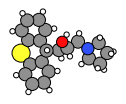

In [2]:
molecule = from_smiles('OC(CC1c2ccccc2Sc2ccccc21)CN1CCCC1')
plot_molecule(molecule)

## Generate conformers with RDKit and UFF
The fastest way to generate conformers is to use RDKit with the UFF force field.

Below we specify to generate 16 initial conformers. The final number of conformers may be smaller, as the geometry optimization may cause several structures to enter the same minimum.

### Conformer generation settings

In [3]:
s = Settings()
s.input.ams.Task = 'Generate'                 # default
s.input.ams.Generator.Method = 'RDKit'        # default
s.input.ams.Generator.RDKit.InitialNConformers = 16    # optional, non-default
s.input.ForceField.Type = 'UFF'               # default

### Conformer generation input file

In [4]:
print(ConformersJob(settings=s).get_input())

Generator
  Method RDKit
  RDKit
    InitialNConformers 16
  End
End

Task Generate

Engine ForceField
  Type UFF
EndEngine




### Run conformer generation

In [5]:
generate_job = ConformersJob(name='generate', molecule=molecule, settings=s)
generate_job.run();

[05.03|08:59:21] JOB generate STARTED
[05.03|08:59:21] JOB generate RUNNING
[05.03|08:59:28] JOB generate FINISHED
[05.03|08:59:28] JOB generate SUCCESSFUL


## Conformer generation results

### Some helper functions

In [6]:
def get_main_results(job:ConformersJob, temperature=298, unit='kcal/mol', return_molecules:bool=True):
    molecules = None
    if return_molecules:
        molecules = job.results.get_conformers()
    energies = job.results.get_relative_energies(unit)
    populations = job.results.get_boltzmann_distribution(temperature)
    
    return molecules, energies, populations

def print_results(job:ConformersJob, temperature=298, unit='kcal/mol'):
    _, energies, populations = get_main_results(job, temperature, unit, return_molecules=False)
    
    print(f"Total # conformers in set: {len(energies)}")
    dE_header = f"ΔE [{unit}]"
    pop_header = f"Pop. (T = {temperature} K)"
    print(f'{"#":>4s} {dE_header:>14s} {pop_header:>18s}')
    
    for i, (E, pop) in enumerate(zip(energies, populations)):
        print(f'{i+1:4d} {E:14.2f} {pop:18.3f}')

def plot_conformers(job:ConformersJob, indices=None, temperature=298, unit='kcal/mol', lowest=True):
    molecules, energies, populations = get_main_results(job)
    
    if isinstance(indices, int):
        N_plot = min(indices, len(energies))
        if lowest:
            indices = list(range(N_plot))
        else:
            indices = np.linspace(0, len(energies)-1, N_plot, dtype=np.int32)
    if indices is None:
        indices = list(range(min(3, len(energies))))
    
    fig, axes = plt.subplots(1, len(indices), figsize=(12,3))
    if len(indices) == 1:
        axes = [axes]

    for ax, i in zip(axes, indices):
        mol = molecules[i]
        E = energies[i]
        population = populations[i]

        plot_molecule(mol, ax=ax)
        ax.set_title(f"#{i+1}\nΔE = {E:.2f} kcal/mol\nPop.: {population:.3f} (T = {temperature} K)")    

### Actual results

Below we see that the **conformer generation gave 14 distinct conformers**, where the highest-energy conformer is 18 kcal/mol higher in energy than the lowest energy conformer.

You can also see the **relative populations** of these conformers at the specified temperature. The populations are calculated from the **Boltzmann distribution** and the relative energies.

In [7]:
unit = 'kcal/mol'
temperature = 298

Total # conformers in set: 14
   #  ΔE [kcal/mol]   Pop. (T = 298 K)
   1           0.00              0.415
   2           0.30              0.249
   3           0.57              0.160
   4           0.82              0.104
   5           1.50              0.033
   6           1.79              0.020
   7           2.25              0.009
   8           2.30              0.009
   9           3.72              0.001
  10           3.76              0.001
  11          13.99              0.000
  12          15.25              0.000
  13          17.96              0.000
  14          18.20              0.000


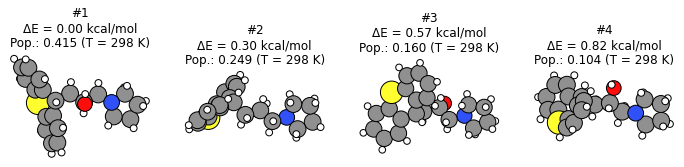

In [8]:
print_results(generate_job, temperature=temperature, unit=unit)
plot_conformers(generate_job, 4, temperature=temperature, unit=unit, lowest=True)  # plot 4 lowest conformers
#plot_conformers(generate_job, 4, temperature=temperature, unit=unit, lowest=False)  # plot 4 conformers from lowest to highest
#plot_conformers(generate_job, [0, 2], temperature=temperature, unit=unit) # plot first and third conformers

## Re-optimize conformers with GFNFF

The UFF force field is not very accurate for geometries and energies. From an initial conformer set you can reoptimize it with a better level of theory.

The **Optimize** task performs **GeometryOptimization** jobs on each conformer in a set.

Below, the 10 most stable conformers (within 8 kcal/mol of the most stable conformer) at the UFF level of theory are re-optimized with GFNFF, which gives more accurate geometries.

In [14]:
s = Settings()
s.input.ams.Task = 'Optimize'
s.input.ams.InputConformersSet = os.path.abspath(generate_job.results.rkfpath())  # must be absolute path
s.input.ams.InputMaxEnergy = 8.0   # only conformers within 8 kcal/mol at the PREVIOUS level of theory
s.input.GFNFF  # or choose a different engine if you don't have a GFNFF license

reoptimize_job = ConformersJob(settings=s, name='reoptimize')
print(reoptimize_job.get_input())

InputConformersSet /home/hellstrom/temp/conformers/plams/plams_workdir/generate/conformers.rkf

InputMaxEnergy 8.0

Task Optimize

Engine GFNFF
EndEngine




In [10]:
reoptimize_job.run();

[05.03|08:59:28] JOB reoptimize STARTED
[05.03|08:59:28] JOB reoptimize RUNNING
[05.03|08:59:32] JOB reoptimize FINISHED
[05.03|08:59:32] JOB reoptimize SUCCESSFUL


Total # conformers in set: 10
   #  ΔE [kcal/mol]   Pop. (T = 298 K)
   1           0.00              0.339
   2           0.22              0.234
   3           0.26              0.217
   4           1.03              0.059
   5           1.07              0.055
   6           1.24              0.042
   7           1.38              0.033
   8           1.78              0.017
   9           2.72              0.003
  10           4.75              0.000


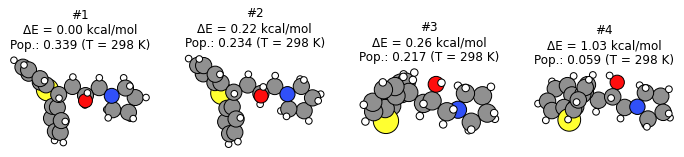

In [11]:
print_results(reoptimize_job, temperature=temperature, unit=unit)
plot_conformers(reoptimize_job, 4, temperature=temperature, unit=unit, lowest=True)

## Score conformers with DFTB

If you have many conformers or a very large molecule, it can be computationally expensive to do the conformer generation or reoptimization and a high level of theory.

The **Score** task runs **SinglePoint** jobs on the conformers in a set. This lets you use a more computationally expensive method. Here, we choose DFTB, although normally you may choose some DFT method.

In [12]:
s = Settings()
s.input.ams.Task = 'Score'
s.input.ams.InputConformersSet = os.path.abspath(reoptimize_job.results.rkfpath())   # must be absolute path
s.input.ams.InputMaxEnergy = 4.0   # only conformers within 4 kcal/mol at the PREVIOUS level of theory
s.input.DFTB.Model = 'GFN1-xTB'   # or choose a different engine if you don't have a DFTB license
#s.input.adf.XC.GGA = 'PBE'                       # to use ADF PBE
#s.input.adf.XC.DISPERSION = 'GRIMME3 BJDAMP'     # to use ADF PBE with Grimme D3(BJ) dispersion

score_job = ConformersJob(settings=s, name='score')
score_job.run();

[05.03|08:59:32] JOB score STARTED
[05.03|08:59:32] JOB score RUNNING
[05.03|08:59:34] JOB score FINISHED
[05.03|08:59:34] JOB score SUCCESSFUL


Total # conformers in set: 9
   #  ΔE [kcal/mol]   Pop. (T = 298 K)
   1           0.00              0.230
   2           0.05              0.210
   3           0.07              0.205
   4           0.24              0.153
   5           0.66              0.075
   6           1.00              0.043
   7           1.04              0.040
   8           1.08              0.037
   9           2.01              0.008


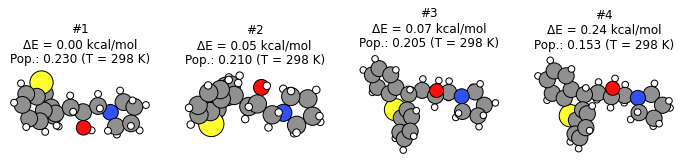

In [13]:
print_results(score_job, temperature=temperature, unit=unit)
plot_conformers(score_job, 4, temperature=temperature, unit=unit, lowest=True)

Here, you see that from the conformers in the set, **DFTB predicts a different lowest-energy conformer than GFNFF** (compare to previous figure).

## Filter a conformer set

In practice, you may have generated thousands of conformers for a particular structure. Many of those conformers may be so high in energy that their Boltzmann weights are very small.

The **Filter** task only filters the conformers, it does not perform any additional calculations. It can be used to reduce a conformer set so that it is more convenient to work with.

Below, we filter the conformers set to only the conformers within 1 kcal/mol of the minimum.

[05.03|09:20:16] JOB filter STARTED
[05.03|09:20:16] JOB filter RUNNING
[05.03|09:20:17] JOB filter FINISHED
[05.03|09:20:17] JOB filter SUCCESSFUL
Total # conformers in set: 6
   #  ΔE [kcal/mol]   Pop. (T = 298 K)
   1           0.00              0.251
   2           0.05              0.229
   3           0.07              0.223
   4           0.24              0.167
   5           0.66              0.082
   6           1.00              0.047


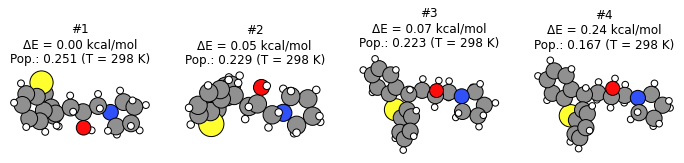

In [16]:
s = Settings()
s.input.ams.Task = 'Filter'
s.input.ams.InputConformersSet = os.path.abspath(score_job.results.rkfpath())
s.input.ams.InputMaxEnergy = 1.0

filter_job = ConformersJob(settings=s, name='filter')
filter_job.run()
print_results(filter_job, temperature=temperature, unit=unit)
plot_conformers(filter_job, 4, temperature=temperature, unit=unit, lowest=True)

The structures and energies are identical to before. However, the relative populations changed slightly as there are now fewer conformers in the set.

## Finish PLAMS

In [17]:
finish()

[05.03|09:34:38] PLAMS run finished. Goodbye


## More about conformers

* Try **CREST** instead of RDKit to generate the initial conformer set

* The **Expand** task can be used to expand a set of conformers.